<h1 style="text-align:center">Predictive Health Insurance Model for Insurance Company</h1>

I will develop a predictive model for a Insurance Company to estimate health insurance
premiums based on factors like age, smoking habits, BMI, and medical history and others.


#### Objective:
- Develop a high-accuracy (>97%) predictive model. The percentage difference between the predicted and actual value on a minimum of 95% of the errors should be less than10%.
- Deploy the model in the cloud so that an insurance underwriter can run it from anywhere.
- Create an interactive Streamlit application that an underwriter can use for predictions.

## Import Library

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set style
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

## Data Collection

## Import dataset

In [2]:
healthcare_df = pd.read_excel("premiums.xlsx")
healthcare_df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Dimensions of dataset

In [3]:
healthcare_df.shape

(50000, 13)

## Data Preparation and EDA

### Information about each feature and its datatypes

In [4]:
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    50000 non-null  int64 
 1   Gender                 50000 non-null  object
 2   Region                 50000 non-null  object
 3   Marital_status         50000 non-null  object
 4   Number Of Dependants   50000 non-null  int64 
 5   BMI_Category           50000 non-null  object
 6   Smoking_Status         49989 non-null  object
 7   Employment_Status      49998 non-null  object
 8   Income_Level           49987 non-null  object
 9   Income_Lakhs           50000 non-null  int64 
 10  Medical History        50000 non-null  object
 11  Insurance_Plan         50000 non-null  object
 12  Annual_Premium_Amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.0+ MB


### Replace column name into same fashion that is lower and snake case

In [5]:
healthcare_df.columns = healthcare_df.columns.str.replace(' ', '_').str.lower()
healthcare_df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


### Handle Duplicates values

In [6]:
healthcare_df.duplicated().sum()
healthcare_df.drop_duplicates(inplace=True)
healthcare_df.duplicated().sum()

0

Since, out data has `no duplicates value` but also we will handle that for future.

### Information about Null value in each column

In [7]:
healthcare_df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

smoking_status feature has `11` 
employment_status feature has `2`
income_level feature has `13` missing data. we need to handel that.

### Basic Descriptive analysis about numerical feature in dataset

In [8]:
healthcare_df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.593480,1.712080,23.018200,15768.116320
std,15.000437,1.498248,24.219197,8419.839675
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,356.000000,5.000000,930.000000,43471.000000


### Count unique value in each column having datatype `object`

In [9]:
healthcare_df.select_dtypes(include='object').nunique()

gender               2
region               4
marital_status       2
bmi_category         4
smoking_status       6
employment_status    3
income_level         4
medical_history      9
insurance_plan       3
dtype: int64

In [10]:
for col in healthcare_df.select_dtypes(include='object').columns:
    print(f"{col}: ", healthcare_df[col].unique())


gender:  ['Male' 'Female']
region:  ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status:  ['Unmarried' 'Married']
bmi_category:  ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status:  ['No Smoking' 'Regular' 'Occasional' nan 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status:  ['Salaried' 'Self-Employed' 'Freelancer' nan]
income_level:  ['<10L' '10L - 25L' '> 40L' '25L - 40L' nan]
medical_history:  ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan:  ['Bronze' 'Silver' 'Gold']


### Handle Repeatative value from smoking_status column

In [11]:
healthcare_df["smoking_status"].value_counts()

smoking_status
No Smoking        27366
Regular           15686
Occasional         6915
Smoking=0             8
Not Smoking           8
Does Not Smoke        6
Name: count, dtype: int64

From above object type column we found that `smoking_status` column has repeated value with same meaning so we will replace with No Smoking because No Smoking label has highest count as compare with others.


    Smoking=0 -> No Smoking
    Does Not Smoke -> No Smoking
    Not Smoking -> No Smoking

In [12]:
healthcare_df.replace({
    'smoking_status': {
        'Smoking=0': 'No Smoking',
        'Not Smoking': 'No Smoking',
        'Does Not Smoke': 'No Smoking'
    }
}, inplace=True)

In [13]:
healthcare_df["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional', nan], dtype=object)

Now, Repeatation for No Smoking has fixed and now its has only 3 unique value.

In [14]:
healthcare_null_df = healthcare_df[healthcare_df.isna().any(axis=1)]

In [15]:
healthcare_null_df[["smoking_status","employment_status", "income_level"]]

,smoking_status,employment_status,income_level
177,NaN,Salaried,> 40L
997,No Smoking,Self-Employed,NaN
7094,Regular,Self-Employed,NaN
15395,No Smoking,Freelancer,NaN
15452,No Smoking,Freelancer,NaN
15648,NaN,Freelancer,25L - 40L
16324,NaN,Salaried,10L - 25L
16941,NaN,Self-Employed,25L - 40L
16975,NaN,Freelancer,<10L
17438,Regular,Self-Employed,NaN


In [16]:
healthcare_null_df.shape

(24, 13)

### Handel null values

In [17]:
# Method 1: Handel null value from each column before that keep copy of origianl dataset
healthcare_dropna_df = healthcare_df.copy()

#### Handle Null Value from `smoking_status` column

In [18]:
healthcare_df["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional', nan], dtype=object)

In [19]:
# Since 'smoking_status is categorical feature we will replace nan value with its frequency i.e MODE'
healthcare_df['smoking_status'] = healthcare_df['smoking_status'].fillna(healthcare_df['smoking_status'].mode().iloc[0])
healthcare_df['smoking_status'].isna().sum()

0

Null value from 'smoking_status has been removed'.

#### Handle Null Value from `employment_status` column

In [20]:
healthcare_df["employment_status"].value_counts()

employment_status
Salaried         20968
Freelancer       15428
Self-Employed    13602
Name: count, dtype: int64

In [21]:
# Since 'employment_status is categorical feature we will replace nan value with its frequency i.e MODE'
healthcare_df['employment_status'] = healthcare_df['employment_status'].fillna(healthcare_df["employment_status"].mode().iloc[0])
healthcare_df['employment_status'].isna().sum()

0

#### Handle Null Value from `income_level` column

In [22]:
healthcare_df["income_level"].value_counts()

income_level
<10L         18667
10L - 25L    14391
25L - 40L    10288
> 40L         6641
Name: count, dtype: int64

In [23]:
healthcare_df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status            0
employment_status         0
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

Before handling Null value from income level. we will figure out what other feature that can influance income_level.

1.   Age  - Yes
2.   Gender - Yes
3.   Region - Yes                
4.   Marital_status - No        
5.   Number Of Dependants - No   
6.   BMI_Category - No           
7.   Smoking_Status - No        
8.   Employment_Status - Yes     
9.   Income_Level - Has Null Value          
10.  Income_Lakhs - Yes        
11.  Medical History - No       
12.  Insurance_Plan - No        
13.  Annual_Premium_Amount - Target to predict



Since, we know that income level is derived from income_in_lakhs. So, we will fill missing income_level with its income_in_lakhs range.

In [24]:

def map_income_level(lakhs):
    if pd.isna(lakhs):
        return None
    elif lakhs < 10:
        return '<10L'
    elif 10 <= lakhs < 25:
        return '10L - 25L'
    elif 25 <= lakhs < 40:
        return '25L - 40L'
    else:
        return '> 40L'

In [25]:
# Apply only where Income_Level is missing
income_level_null = healthcare_df['income_level'].isna()
healthcare_df.loc[income_level_null, 'income_level'] =  healthcare_df.loc[income_level_null, 'income_lakhs'].apply(map_income_level)

In [26]:
healthcare_df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [27]:
healthcare_df.shape

(50000, 13)

We, have removed null value from all income_level feature.

In [28]:
# Method 2: Drop Null Value rows, Since we have very few null values
healthcare_dropna_df.dropna(inplace=True)
print(healthcare_dropna_df.isna().sum())
print("New Dimension of dataset", healthcare_dropna_df.shape)

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64
New Dimension of dataset (49976, 13)


In [29]:
print("Dataframe where Null value is fixed", healthcare_df.shape)
print("Dataframe where Null value is droped", healthcare_dropna_df.shape)

Dataframe where Null value is fixed (50000, 13)
Dataframe where Null value is droped (49976, 13)


In [30]:
healthcare_df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.593480,1.712080,23.018200,15768.116320
std,15.000437,1.498248,24.219197,8419.839675
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,356.000000,5.000000,930.000000,43471.000000


From above descriptive analysis. It is found that age, number_of_dependants has major issues because age cannot be maximum upto 356 and number_of_dependants in negative.
Also, income_lakhs has some outlier 'its shows right skewed'

### Handle number_of_dependants column

In [31]:
healthcare_df['number_of_dependants'].value_counts()

number_of_dependants
 0    15434
 3    11013
 1     8677
 2     8423
 4     4727
 5     1654
-1       40
-3       32
Name: count, dtype: int64

Here i found that there are 72 rows which has number_of_dependants in negative. So, as per our business requirement we decided to make it positive.

In [32]:
healthcare_df['number_of_dependants'] = abs(healthcare_df['number_of_dependants'])
healthcare_df['number_of_dependants'].describe()

count    50000.000000
mean         1.717520
std          1.492009
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [33]:
numeric_columns = healthcare_df.select_dtypes(["float64", "int64"]).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

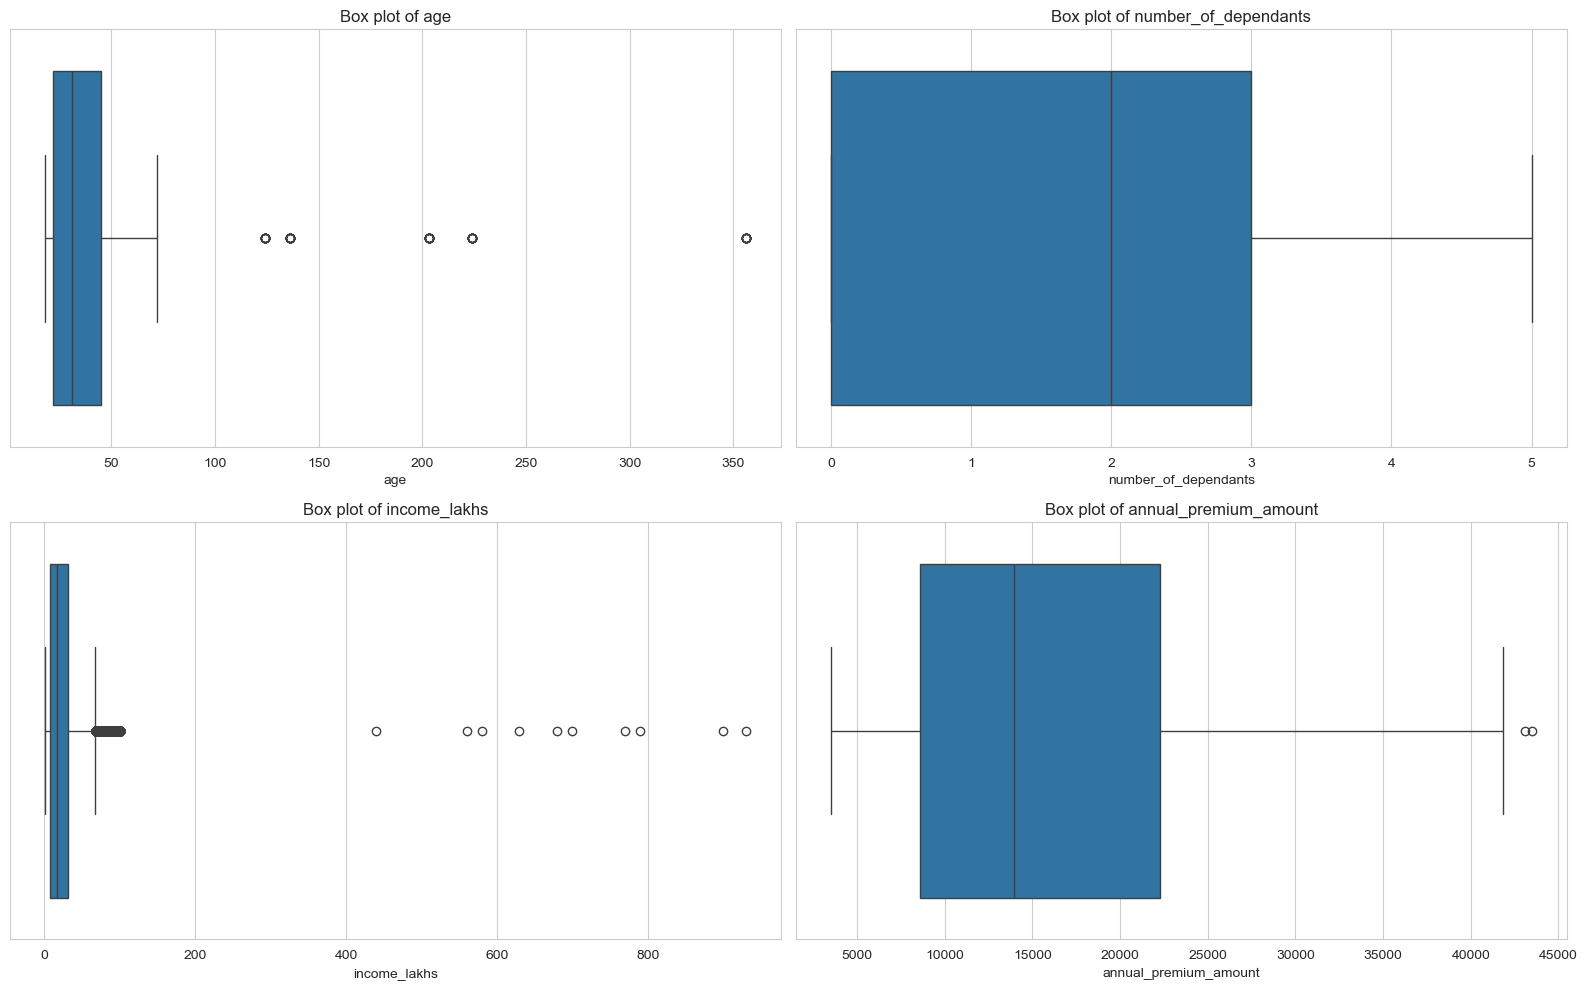

In [34]:

# Create subplots: 2 rows, 2 columns
num_rows = 2
fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each numerical column
for i, num_col in enumerate(numeric_columns):
    sns.boxplot(x=healthcare_df[num_col], ax=axes[i])
    axes[i].set_title(f'Box plot of {num_col}')
    axes[i].set_xlabel(num_col)

# Hide any unused subplots
for i in range(len(num_col), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

Only age and income_lakhs has outlier needed to be remove and we will leave annual_premium_amount because common to have some expensive premium sometime, based on our business knowledge and number_of_dependent has no outliers

### Handel age column

In [35]:
healthcare_df[healthcare_df['age'] < 89]['age'].describe()

count    49942.000000
mean        34.403648
std         13.682354
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

In [36]:
healthcare_df[healthcare_df['age'] < 100]['age'].describe()

count    49942.000000
mean        34.403648
std         13.682354
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

In [37]:

# Calculate the median of ages < 100
median_age = int(healthcare_df.loc[healthcare_df['age'] < 100, 'age'].median())

# Replace ages > 100 with the median
healthcare_df.loc[healthcare_df['age'] > 100, 'age'] = median_age

In [38]:
healthcare_df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.399700,1.717520,23.018200,15768.116320
std,13.674907,1.492009,24.219197,8419.839675
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,72.000000,5.000000,930.000000,43471.000000


Outlier are removed from age column

### Handle income_lakh

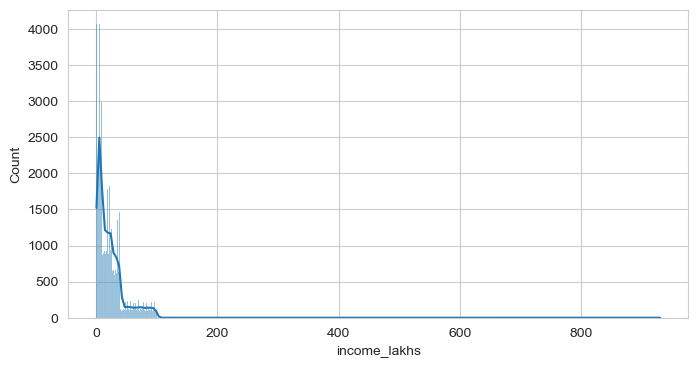

In [39]:
plt.figure(figsize=(8,4))
sns.histplot(x='income_lakhs', data=healthcare_df, kde=True)
plt.show()

we will use IQR method to remove outlier from income_lakhs column.

In [40]:
def get_iqr_bound(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


In [41]:
get_iqr_bound(healthcare_df['income_lakhs'])

(-29.0, 67.0)

From IQR method we got lower_bound as -29.0 and upper_bound as 67 which is very common to have that much salary in a year even more. So, we will business knowledge for upper bound i.e 100 lakhs

In [42]:
quantile_thresold = healthcare_df['income_lakhs'].quantile(0.999)
quantile_thresold

100.0

In [43]:
healthcare_df[healthcare_df['income_lakhs']>quantile_thresold].shape

(10, 13)

Its only 10 records. So, we will drop these rows grater than quantile_thresold.

In [44]:
healthcare_df = healthcare_df[healthcare_df['income_lakhs'] <= quantile_thresold]
healthcare_df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49990.000000,49990.000000,49990.000000,49990.000000
mean,34.399440,1.717544,22.883177,15767.268374
std,13.674909,1.491966,22.164664,8419.377502
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22274.500000
max,72.000000,5.000000,100.000000,43471.000000


### Univariant Analysis on Numerical Feature

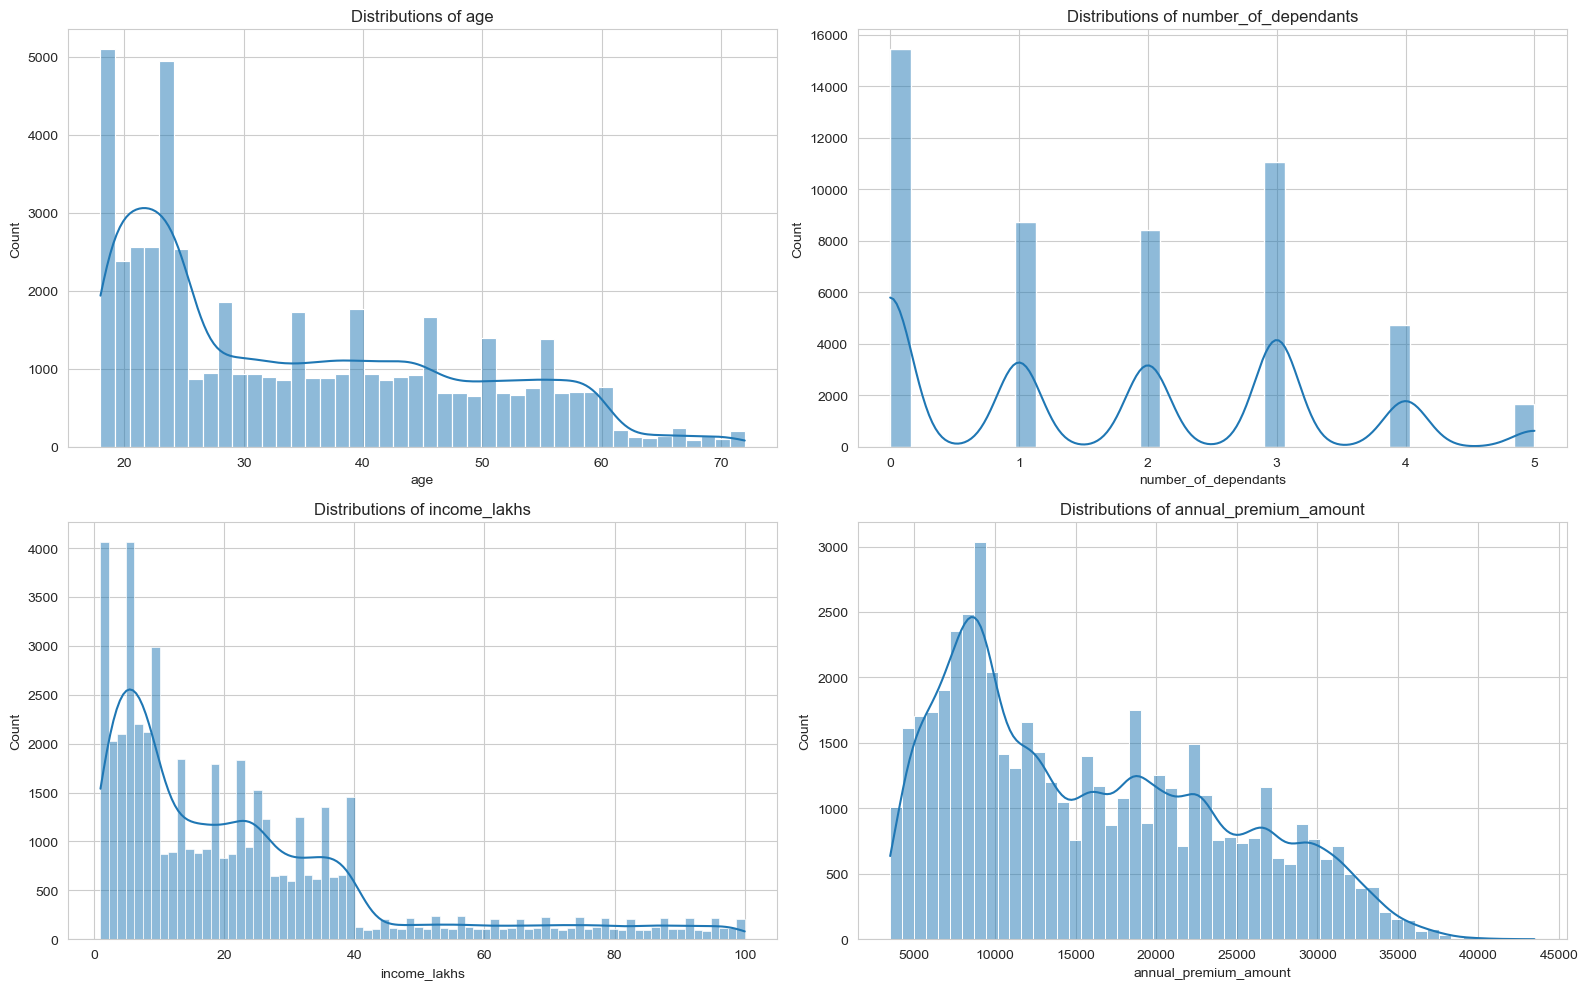

In [45]:
df = healthcare_df.copy()

# Create subplots: 2 rows, 2 columns
num_rows = 2
fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each numerical column
for i, num_col in enumerate(numeric_columns):
    sns.histplot(x=df[num_col], data=df, kde=True, ax=axes[i])
    axes[i].set_title(f'Distributions of {num_col}')
    axes[i].set_xlabel(num_col)

# Hide any unused subplots
for i in range(len(num_col), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

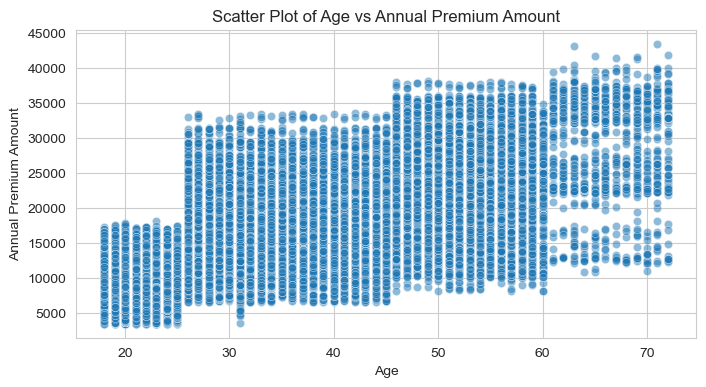

In [46]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='age', y='annual_premium_amount', data=healthcare_df, alpha=0.5)
plt.title('Scatter Plot of Age vs Annual Premium Amount')
plt.xlabel('Age')
plt.ylabel('Annual Premium Amount')
plt.show()

We can see that as per age increases Annual Premium Amount is also increases.

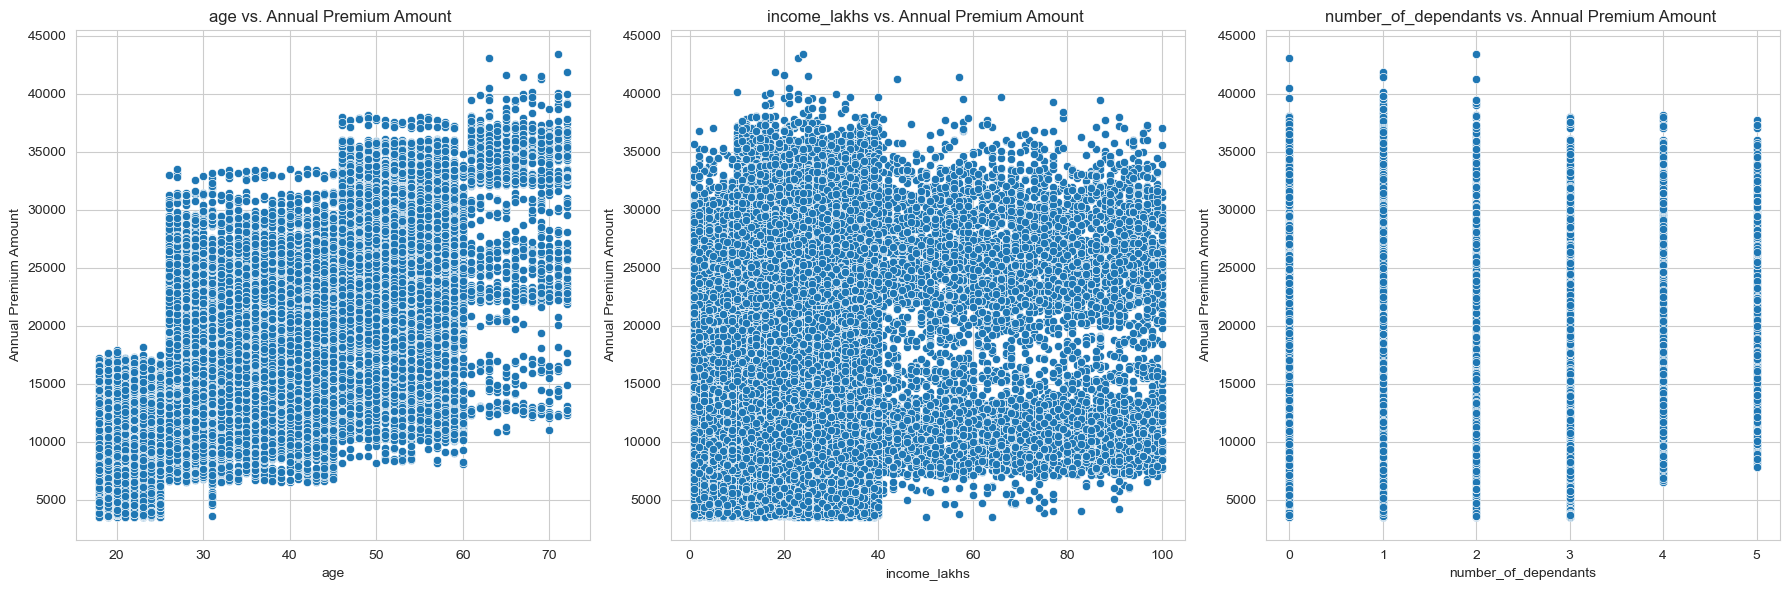

In [47]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']
fig, axes = plt. subplots(1, len (numeric_features), figsize=(18, 6)) # Adjust figure s
for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=healthcare_df[column], y=healthcare_df['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount ')
    ax.set_xlabel (column)
    ax.set_ylabel('Annual Premium Amount')
plt. tight_layout () # Adjust Layout
plt. show()

### Univariant Analysis on Categorical Feature

In [48]:
categorical_cols = healthcare_df.select_dtypes(include="object").columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

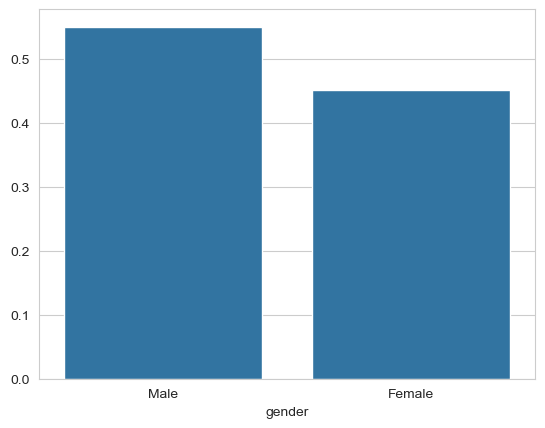

In [49]:
pct_count = healthcare_df['gender'].value_counts(normalize=True)
sns.barplot(x= pct_count.index, y = pct_count.values)
plt.show()

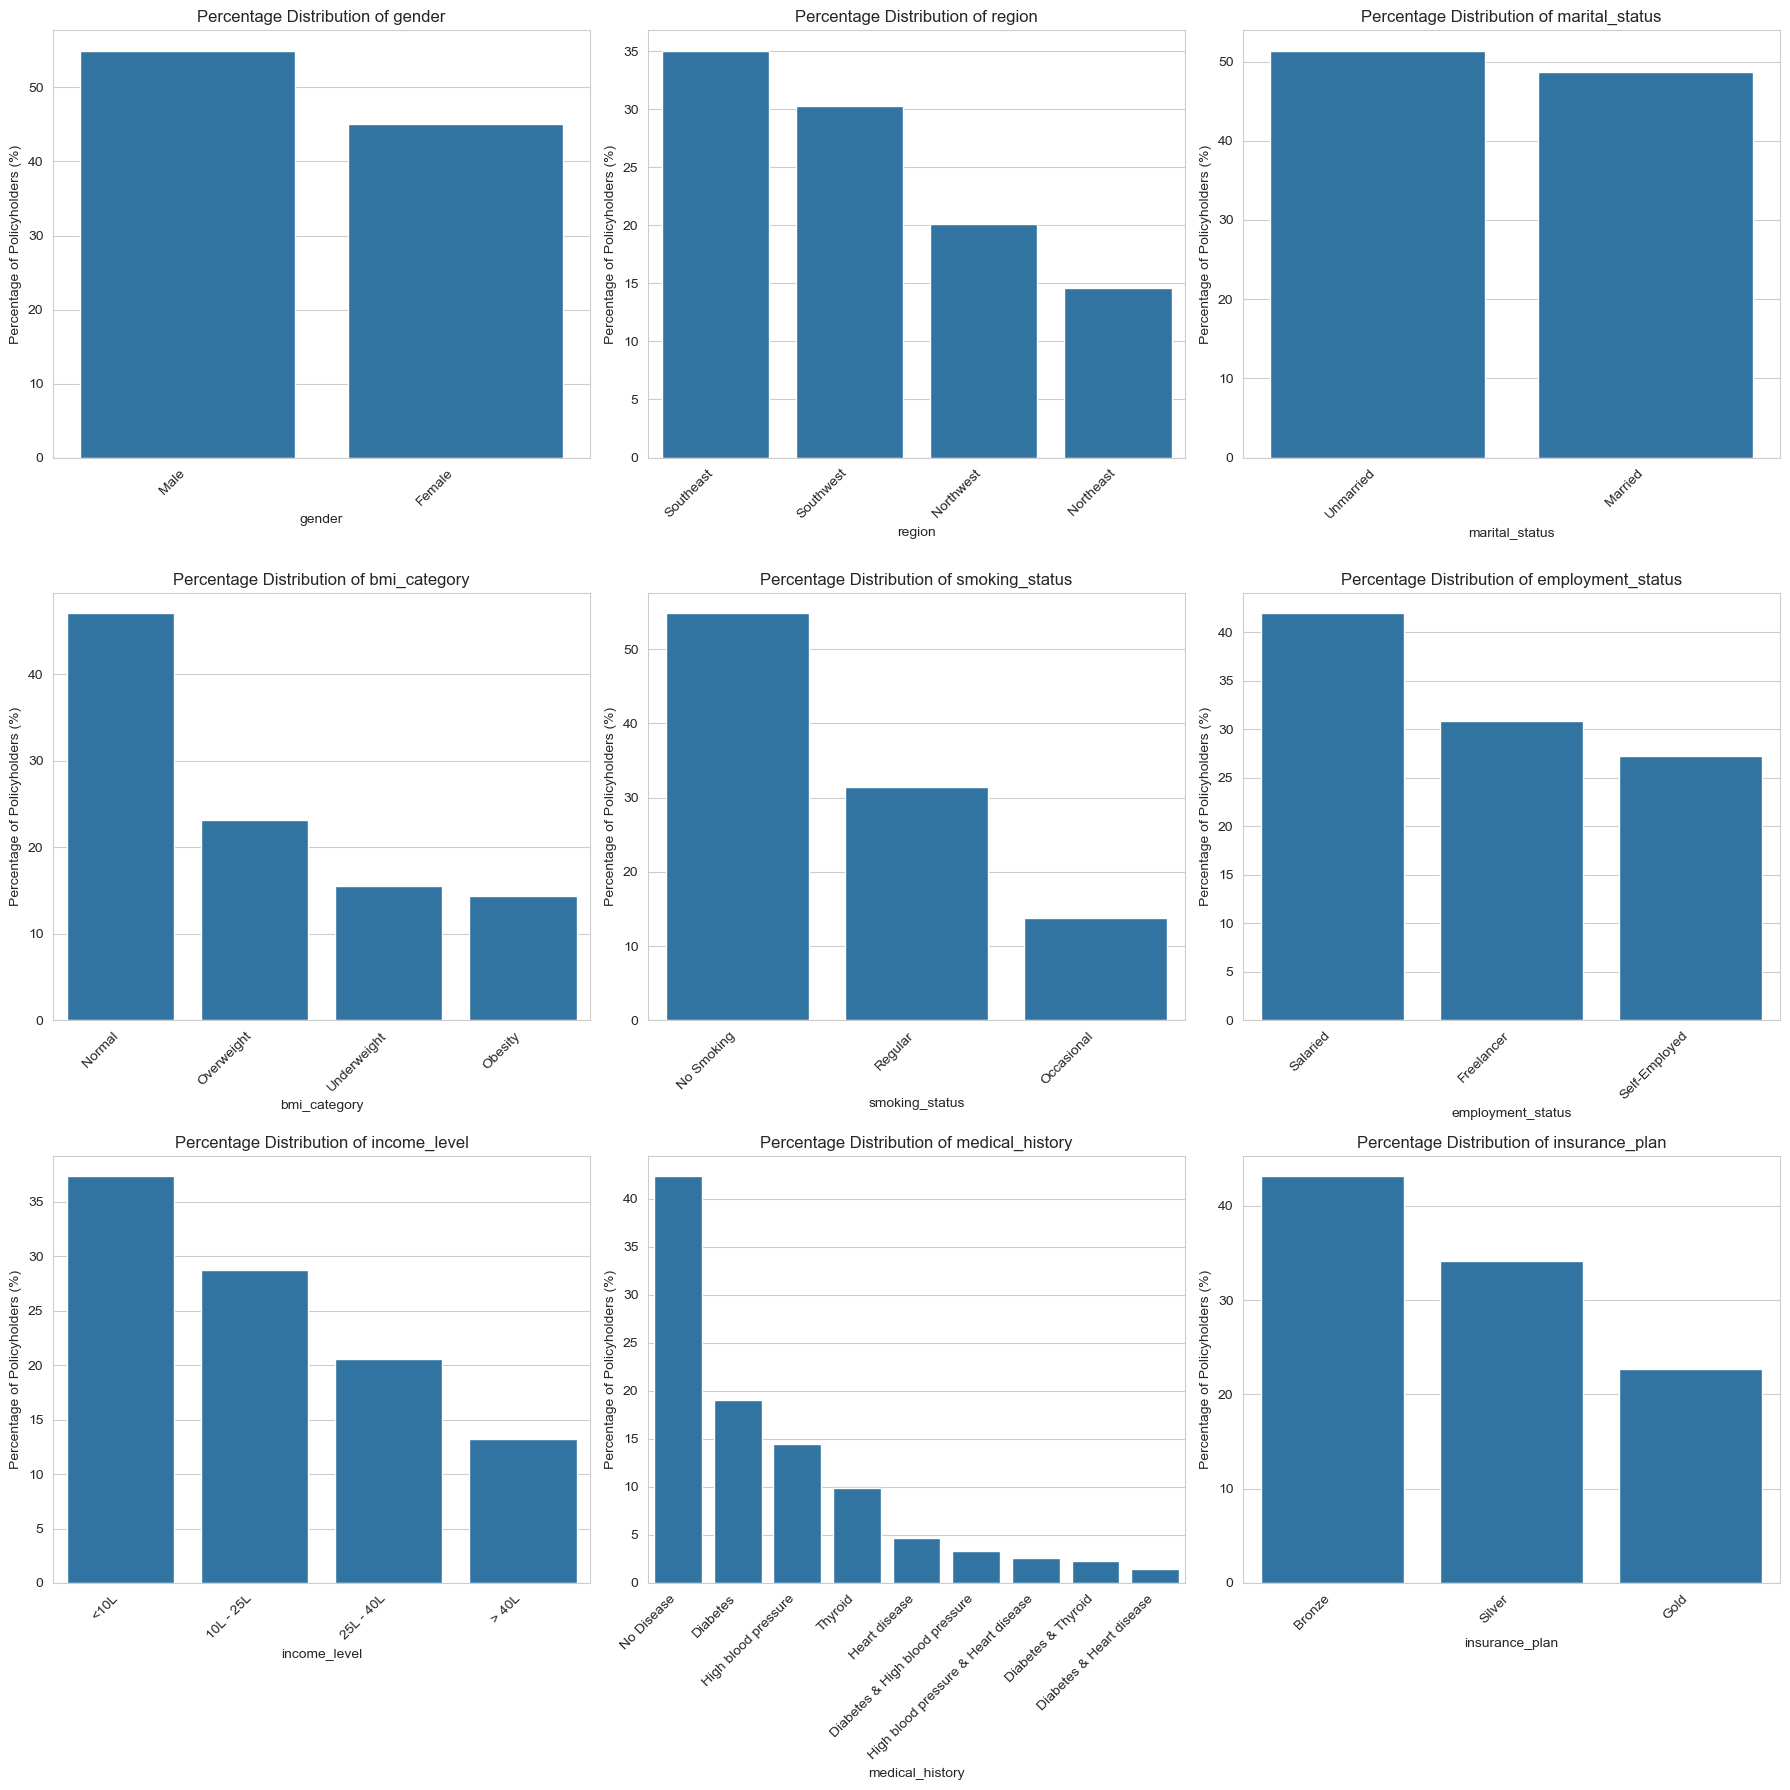

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18)) # Adjust figure size as necessary
axes = axes.flatten() # Flatten the 2D array of axes into 1D for easier iteration


for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = healthcare_df[column].value_counts(normalize=True) * 100 # normalize=True gives relative value
    
    # Plotting the distribution using barplot
    sns. barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel( 'Percentage of Policyholders (%)')
    ax.set_xlabel(column) # Set xlabel to the column name for clarity
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
plt. tight_layout() # Adjusts plot parameters for better fit in the figure window
plt. show()

Here are the insights from each plot in your univariate analysis of categorical variables:

1. Gender:
    Male (~55%) slightly outnumbers Female (~45%).
    Indicates a male-dominant policyholder base.

2. Region:
    Majority are from the Southeast (~33%) and Southwest (~30%).
    Northwest (~20%) and Northeast (~15%) have smaller shares.
    Shows a geographical concentration in the South.

3. Marital Status:
    Fairly balanced between Married (~52%) and Unmarried (~48%).
    Indicates no dominant marital status among policyholders.

4. BMI Category:
    Most are in the Normal (~45%) category.
    Overweight (~25%), Underweight (~15%), and Obesity (~12%) follow.
    Suggests a generally healthy BMI distribution, but notable overweight presence.

5. Smoking Status:
    Non-smokers (~56%) form the majority.
    Regular smokers (~32%) and Occasional smokers (~15%) are present but less dominant.
    Indicates a health-conscious customer base.

6. Employment Status:
    Salaried (~45%) is the largest group.
    Retired (~33%) is significant.
    Self-employed (~27%) is the smallest group.
    Points to a stable income base, with many retirees as well.

7. Income Level:
    Skewed towards the <10k (~38%) bracket.
    10k-20k (~28%), 20k-40k (~21%), >40k (~13%) follow.
    Suggests a low-to-middle income clientele.

8. Medical History:
    No disease (~43%) is the most common.
    Diabetes (~18%), High BP (~14%), Thyroid (~9%), and others trail off.
    Chronic conditions exist but not in alarming proportions.

9. Insurance Plan:
    Bronze (~45%) is the most common plan.
    Silver (~35%) and Gold (~23%) follow.
    Indicates cost-sensitive customers opting for basic coverage.

### Bivariant Analysis on Categorical Variable

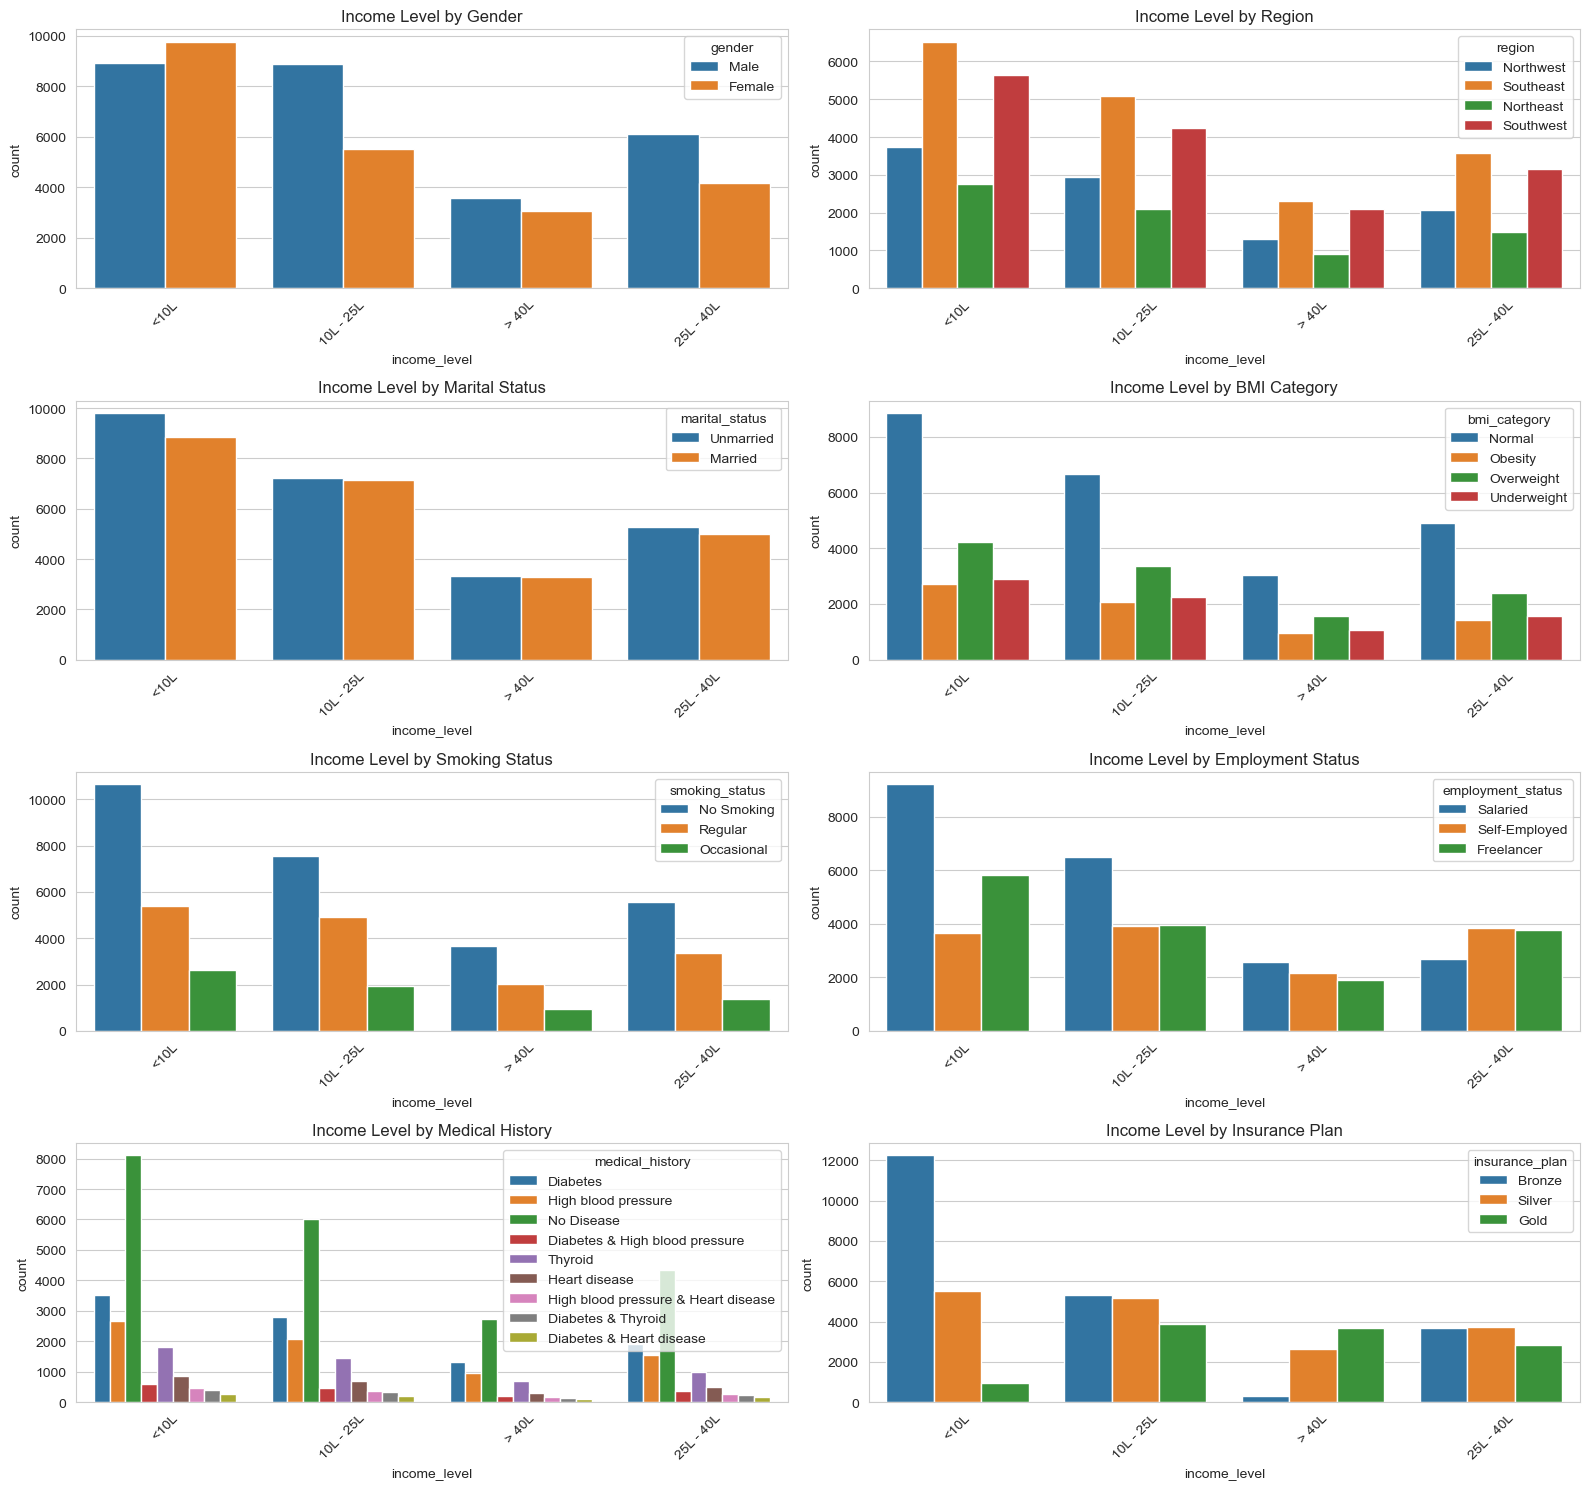

In [51]:
# Create subplots: 4 rows, 4 columns
fig, axes = plt.subplots(4, 2, figsize=(16, 15))
axes = axes.flatten()

# -----------------------------
# 1. Bar Plot: Gender vs Income_Level
sns.countplot(data=df, x='income_level', hue='gender', ax=axes[0])
axes[0].set_title('Income Level by Gender')
axes[0].tick_params(axis='x', rotation=45)

# -----------------------------
# 2. Bar Plot: Region vs Income_Level
sns.countplot(data=df, x='income_level', hue='region', ax=axes[1])
axes[1].set_title('Income Level by Region')
axes[1].tick_params(axis='x', rotation=45)

# -----------------------------
# 3. Bar Plot: Marital Status vs Income_Level
sns.countplot(data=df, x='income_level', hue='marital_status', ax=axes[2])
axes[2].set_title('Income Level by Marital Status')
axes[2].tick_params(axis='x', rotation=45)

# -----------------------------
# 4. Bar Plot: BMI Category vs Income_Level
sns.countplot(data=df, x='income_level', hue='bmi_category', ax=axes[3])
axes[3].set_title('Income Level by BMI Category')
axes[3].tick_params(axis='x', rotation=45)

# -----------------------------
# 5. Bar Plot: Smoking Status vs Income_Level
sns.countplot(data=df, x='income_level', hue='smoking_status', ax=axes[4])
axes[4].set_title('Income Level by Smoking Status')
axes[4].tick_params(axis='x', rotation=45)

# -----------------------------
# 6. Bar Plot: Employment_Status vs Income_Level
sns.countplot(data=df, x='income_level', hue='employment_status', ax=axes[5])
axes[5].set_title('Income Level by Employment Status')
axes[5].tick_params(axis='x', rotation=45)

# -----------------------------
# 7. Bar Plot: Medical History vs Income_Level
sns.countplot(data=df, x='income_level', hue='medical_history', ax=axes[6])
axes[6].set_title('Income Level by Medical History')
axes[6].tick_params(axis='x', rotation=45)

# -----------------------------
# 8. Bar Plot: Insurance Plan vs Income_Level
sns.countplot(data=df, x='income_level', hue='insurance_plan', ax=axes[7])
axes[7].set_title('Income Level by Insurance Plan')
axes[7].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


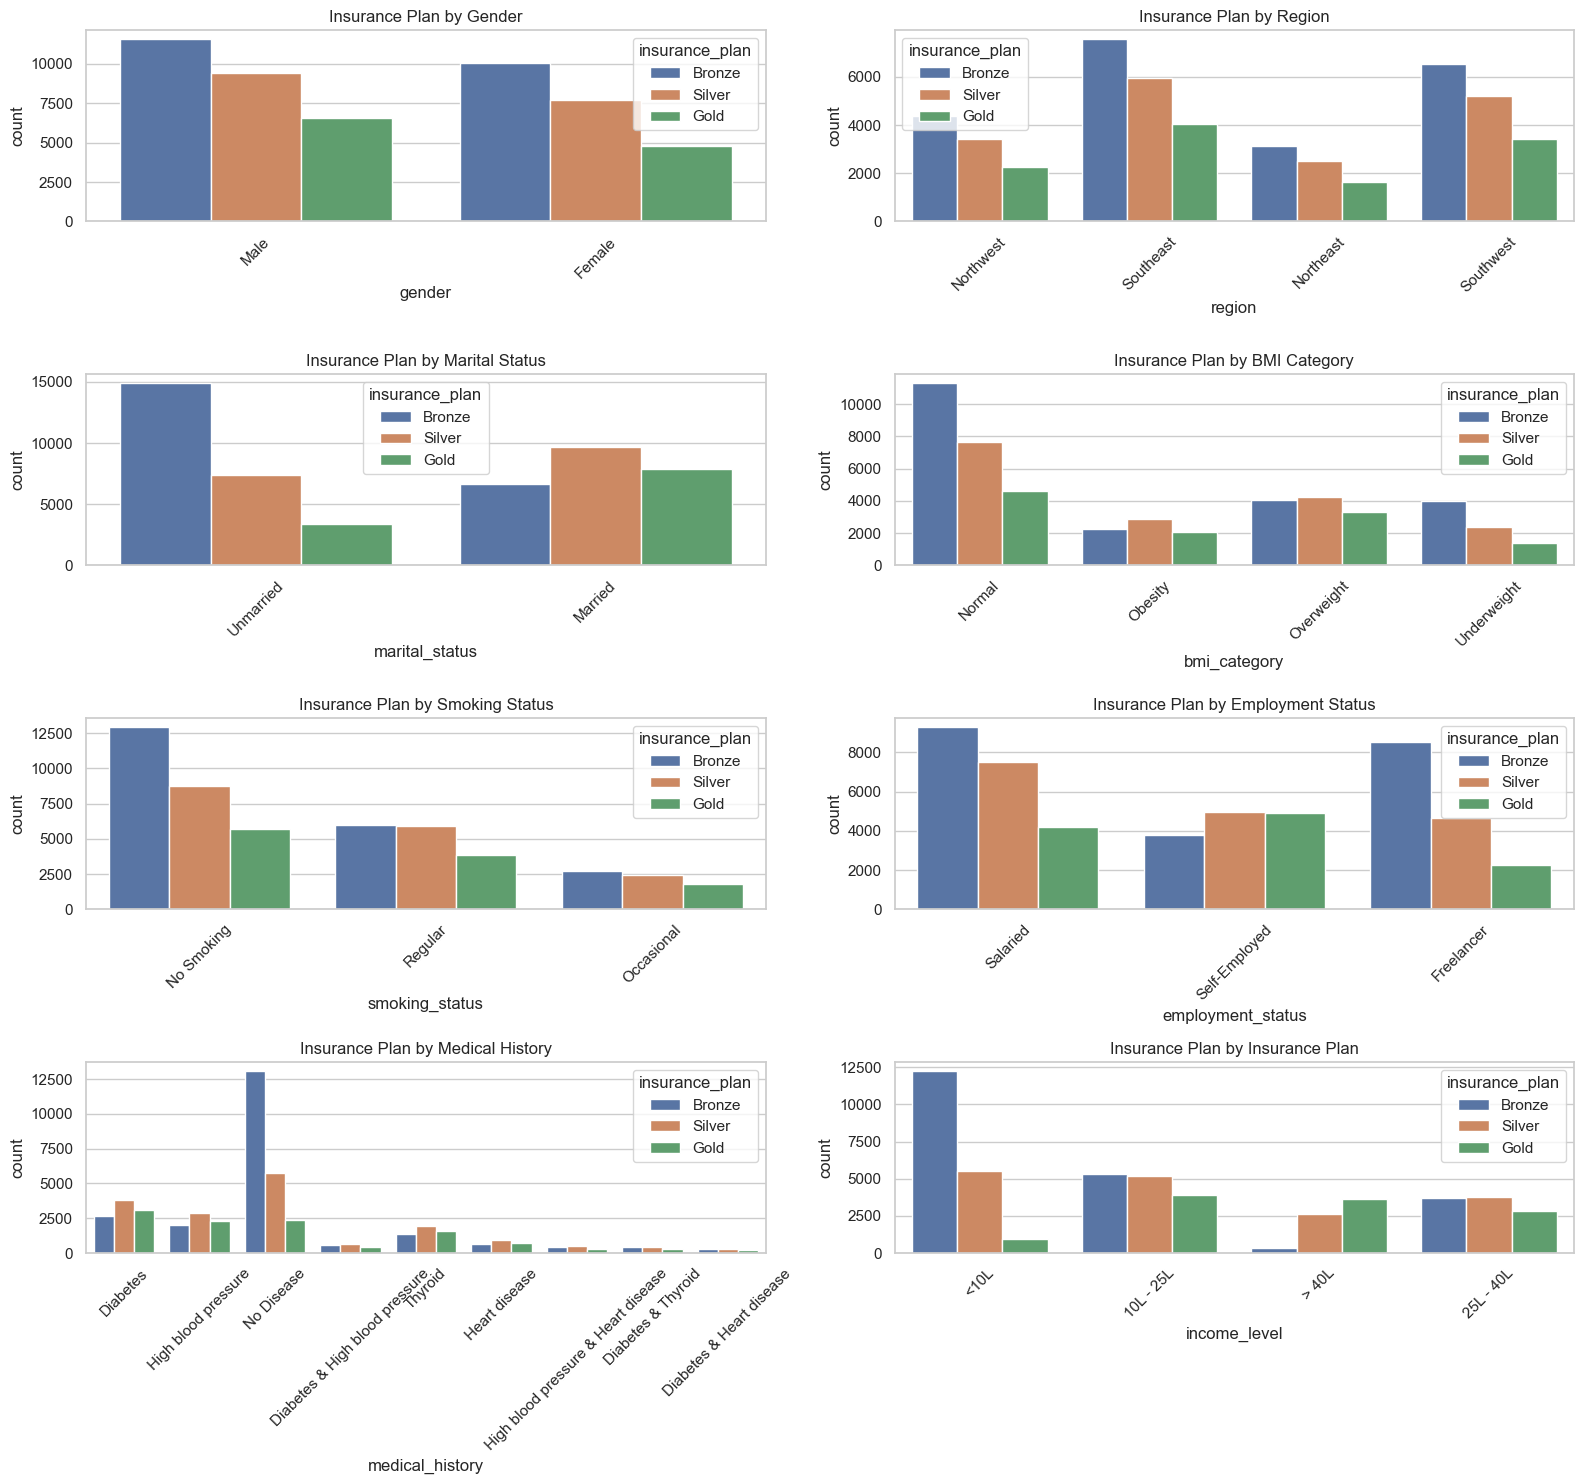

In [52]:
# Set style
sns.set(style='whitegrid')

# Create subplots: 4 rows, 4 columns
fig, axes = plt.subplots(4, 2, figsize=(16, 15))
axes = axes.flatten()

# -----------------------------
# 1. Bar Plot: Gender vs insurance_plan
sns.countplot(data=df, x='gender', hue='insurance_plan', ax=axes[0])
axes[0].set_title('Insurance Plan by Gender')
axes[0].tick_params(axis='x', rotation=45)

# -----------------------------
# 2. Bar Plot: Region vs insurance_plan
sns.countplot(data=df, x='region', hue='insurance_plan', ax=axes[1])
axes[1].set_title('Insurance Plan by Region')
axes[1].tick_params(axis='x', rotation=45)

# -----------------------------
# 3. Bar Plot: Marital Status vs insurance_plan
sns.countplot(data=df, x='marital_status', hue='insurance_plan', ax=axes[2])
axes[2].set_title('Insurance Plan by Marital Status')
axes[2].tick_params(axis='x', rotation=45)

# -----------------------------
# 4. Bar Plot: BMI Category vs insurance_plan
sns.countplot(data=df, x='bmi_category', hue='insurance_plan', ax=axes[3])
axes[3].set_title('Insurance Plan by BMI Category')
axes[3].tick_params(axis='x', rotation=45)

# -----------------------------
# 5. Bar Plot: Smoking Status vs insurance_plan
sns.countplot(data=df, x='smoking_status', hue='insurance_plan', ax=axes[4])
axes[4].set_title('Insurance Plan by Smoking Status')
axes[4].tick_params(axis='x', rotation=45)

# -----------------------------
# 6. Bar Plot: Employment_Status vs insurance_plan
sns.countplot(data=df, x='employment_status', hue='insurance_plan', ax=axes[5])
axes[5].set_title('Insurance Plan by Employment Status')
axes[5].tick_params(axis='x', rotation=45)

# -----------------------------
# 7. Bar Plot: Medical History vs insurance_plan
sns.countplot(data=df, x='medical_history', hue='insurance_plan', ax=axes[6])
axes[6].set_title('Insurance Plan by Medical History')
axes[6].tick_params(axis='x', rotation=45)

# -----------------------------
# 8. Bar Plot: Insurance Plan vs Income_Level
sns.countplot(data=df, x='income_level', hue='insurance_plan', ax=axes[7])
axes[7].set_title('Insurance Plan by Insurance Plan')
axes[7].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


These are Bivariant analysis between all categorical feature vs Insurance Plan and Income Level.

## Feature Engineering

In [53]:
healthcare_df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [54]:
for col in healthcare_df.select_dtypes(include="object").columns:
    print(f"{col}: ", healthcare_df[col].unique())


gender:  ['Male' 'Female']
region:  ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status:  ['Unmarried' 'Married']
bmi_category:  ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status:  ['No Smoking' 'Regular' 'Occasional']
employment_status:  ['Salaried' 'Self-Employed' 'Freelancer']
income_level:  ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history:  ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan:  ['Bronze' 'Silver' 'Gold']


### Handel medical_history column from categorical to numerical value

In [55]:
# As per business knowledge
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [56]:
feature_eng_df = healthcare_df.copy()


In [57]:
feature_eng_df[["disease1","disease2"]] = feature_eng_df['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
feature_eng_df.sample(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
42329,35,Female,Southeast,Married,4,Normal,Occasional,Salaried,10L - 25L,11,Thyroid,Silver,16756,thyroid,None
29060,38,Female,Southwest,Married,5,Underweight,Occasional,Freelancer,> 40L,70,Thyroid,Gold,24050,thyroid,None


In [58]:
feature_eng_df.fillna({
    'disease1': 'none',
    'disease2': 'none'
}, inplace=True)
feature_eng_df['total_risk_score'] = 0

In [59]:
feature_eng_df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
total_risk_score         0
dtype: int64

#### Total risk score is added by using disease1 and disease2 column and also normalized the total risk score using min-max scalar

In [60]:
for disease in ["disease1","disease2"]:
    feature_eng_df['total_risk_score'] +=  feature_eng_df[disease].map(risk_scores)

max_score = feature_eng_df['total_risk_score'].max()
min_score = feature_eng_df['total_risk_score'].min()
feature_eng_df['normalized_risk_score'] = (feature_eng_df['total_risk_score'] - min_score)/ (max_score - min_score)
feature_eng_df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


### Handel insurance_plan column from categorical to numerical value

In [61]:
feature_eng_df['insurance_plan'] = feature_eng_df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
feature_eng_df['insurance_plan'].unique()

array([1, 2, 3])

Since insurance_plan is ordinal data — with a natural order of Bronze < Silver < Gold — we can use label encoding. Alternatively, because there are only a few categories, we can manually assign numeric values while preserving their order.

### Handle income_level

In [62]:
feature_eng_df['income_level'] = feature_eng_df['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})
feature_eng_df['income_level'].unique()

array([1, 2, 4, 3])

### Handle bmi_category, smoking_status, employment_status, marital_status, region, gender

Since, these feature are label data. We will use One-Hot Encoding for these to convert from categorical to numerical

In [63]:
# Step 1: One-hot encode with get_dummies
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
feature_eng_df_new = pd.get_dummies(feature_eng_df, columns=nominal_cols, drop_first=True, dtype=int)

# Step 2: Rename columns to make both sides of underscore lowercase
feature_eng_df_new.columns = [
    '_'.join(part.lower() for part in col.split('_')) if '_' in col else col.lower()
    for col in feature_eng_df_new.columns
]
feature_eng_df_new.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [64]:
feature_eng_df_new = feature_eng_df_new.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
feature_eng_df_new.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


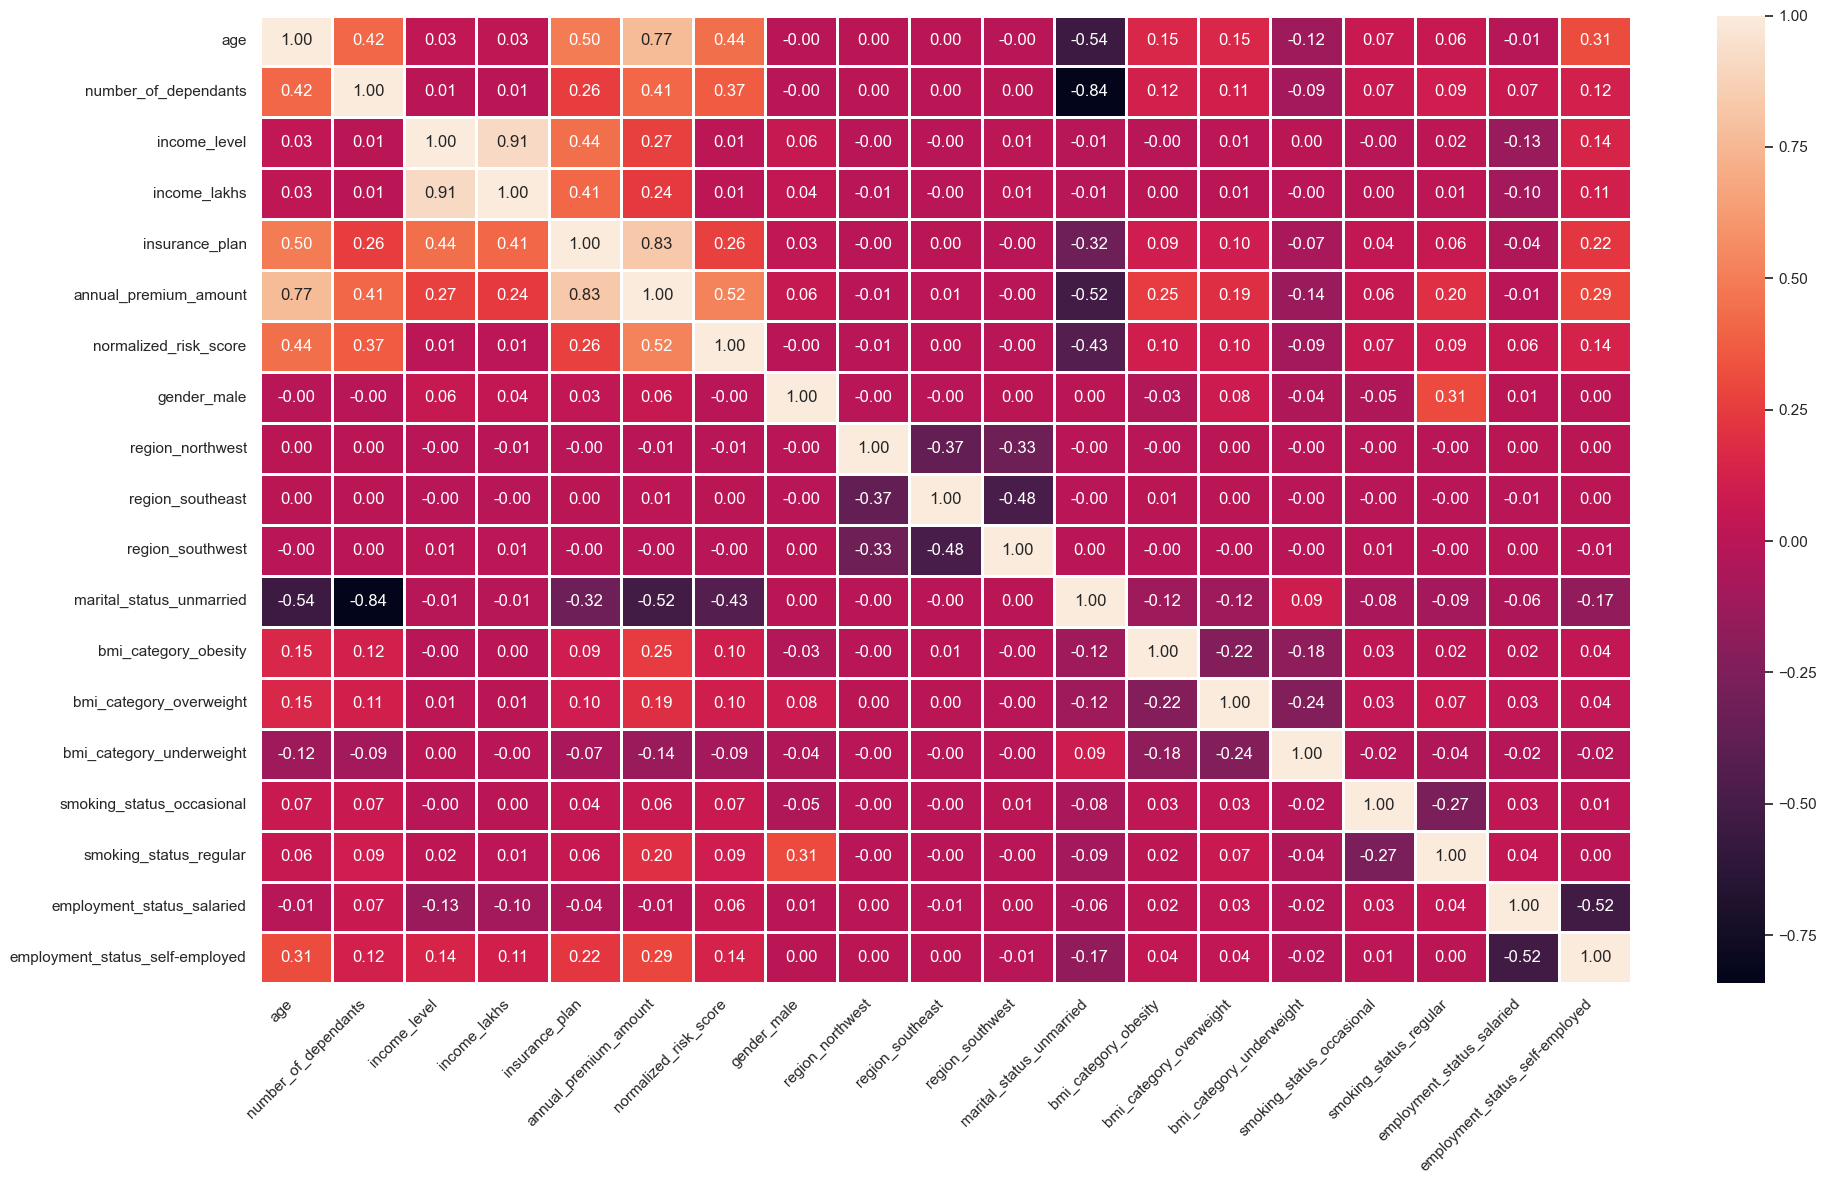

In [65]:
corr_metrix = feature_eng_df_new.corr()

plt.figure(figsize=(20,12))
sns.heatmap(corr_metrix, annot=True, fmt='.2f', linewidths=0.8)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Selection

In [66]:
X = feature_eng_df_new.drop("annual_premium_amount", axis=1)
y = feature_eng_df_new['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ["age", "number_of_dependants", "income_level", "income_lakhs", "insurance_plan"]
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
count,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000,49990.000000
mean,0.303693,0.343509,0.365806,0.221042,0.397499,0.291838,0.549630,0.200860,0.350410,0.303061,0.513623,0.143229,0.231146,0.155371,0.138288,0.313763,0.419404,0.272054
std,0.253239,0.298393,0.349697,0.223885,0.392441,0.287442,0.497536,0.400648,0.477103,0.459586,0.499819,0.350309,0.421570,0.362262,0.345205,0.464026,0.493466,0.445022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Columns'] = data.columns
    vif_df['VIF'] = [ variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,Columns,VIF
0,age,4.562531
1,number_of_dependants,4.533741
2,income_level,12.446871
3,income_lakhs,11.181936
4,insurance_plan,3.584638
5,normalized_risk_score,2.687465
6,gender_male,2.421364
7,region_northwest,2.101910
8,region_southeast,2.921793
9,region_southwest,2.670299


In [68]:
calculate_vif(X.drop('income_level', axis=1))


,Columns,VIF
0,age,4.540946
1,number_of_dependants,4.525654
2,income_lakhs,2.480307
3,insurance_plan,3.445518
4,normalized_risk_score,2.687198
5,gender_male,2.409916
6,region_northwest,2.100167
7,region_southeast,2.919226
8,region_southwest,2.667967
9,marital_status_unmarried,3.392531


In [69]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


Feature selection is completed and ready for Training model.
Selected features are 
['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan', 'normalized_risk_score', 'gender_male', 'region_northwest', 'region_southeast', 'region_southwest', 'marital_status_unmarried' 'bmi_category_obesity', 'bmi_category_overweight','bmi_category_underweight', 'smoking_status_occasional',
'smoking_status_regular', 'employment_status_salaried', 'employment_status_self-employed']

## Model Training and Selection

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size= 0.3, random_state= 43)
print("X train: ", X_train.shape)
print("X test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

X train:  (34993, 17)
X test:  (14997, 17)
y train:  (34993,)
y test:  (14997,)


In [71]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score =model_lr.score(X_test, y_test)
train_score =model_lr.score(X_train, y_train)
print(f"Train score : {train_score}  Test score: {test_score}")

Train score : 0.9275620794095728  Test score: 0.9290301609048962


In [72]:
print('Values of m(slope) for each column :\n', model_lr.coef_)


Values of m(slope) for each column :
 [ 1.12071452e+04 -6.51777159e+02 -3.98676549e+02  1.25059088e+04
  4.81663732e+03  1.51779608e+02 -7.23204214e+01 -3.52386315e+00
 -6.27830791e+01 -9.24181310e+02  3.37801277e+03  1.60700783e+03
  3.68233792e+02  7.25490301e+02  2.22936972e+03  1.33328989e+02
  3.75152161e+02]


In [73]:
print('Values of intercept on hyper-plane :', model_lr.intercept_)

Values of intercept on hyper-plane : 4856.65269452639


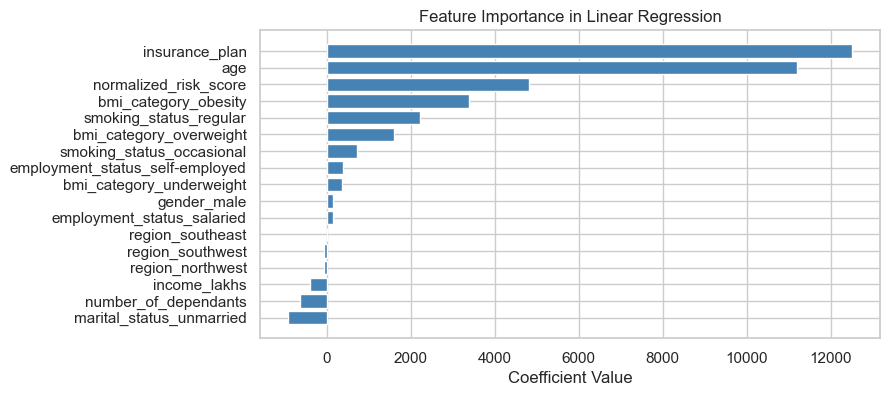

In [74]:
feature_importance = model_lr.coef_
coef_df = pd.DataFrame(data = feature_importance, index= X_test.columns, columns=['coefficients'])
coef_df.head()


coef_df = coef_df.sort_values(by='coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['coefficients'], color='steelblue')
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Linear Regression")
plt.show()


In [75]:
model_rg = Ridge(alpha=10)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9275583450362493, 0.9290163227844338)

In [76]:
y_pred = model_rg.predict(X_test)
mse_lr = mean_squared_error (y_test, y_pred)
rmse_lr= np.sqrt(mse_lr)
print("GBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

GBoost Regression ==> MSE:  5059240.968205247 RMSE:  2249.2756541173976


In [77]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.986106276512146, 0.980435848236084)

In [78]:
y_pred = model_xgb.predict(X_test)
mse_xg = mean_squared_error (y_test, y_pred)
rmse_xg= np.sqrt(mse_xg)
print("GBoost Regression ==> MSE: ", mse_xg, "RMSE: ", rmse_xg)

GBoost Regression ==> MSE:  1394403.9239858328 RMSE:  1180.8488150418889


## Model Fine Tunning

##### RandomizedSearchCV Hyperparameter Tuning

In [79]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1,0.2],
    'max_depth': [3, 4, 5],

}
random_search = RandomizedSearchCV(
    estimator = model_xgb, 
    param_distributions = param_grid, 
    n_iter=10, 
    cv=3, 
    scoring='r2',
    n_jobs=-1,   # Uses all available CPU cores
    verbose=1    # Optional: shows progress
    )
random_search.fit(X_train, y_train)

# Show the best score
print("Best R2 score:", random_search.best_score_)

# Optional: Best hyperparameters
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best R2 score: 0.9793009360631307
Best Parameters: {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.1}


##### GridSearchCV Hyperparameter Tuning

In [80]:
# Define the model
model_xgb = XGBRegressor()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,   # Uses all available CPU cores
    verbose=1    # Optional: shows progress
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Show the best score
print("Best R2 score:", grid_search.best_score_)

# Optional: Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best R2 score: 0.9816259741783142
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}


In [81]:
best_model = grid_search.best_estimator_

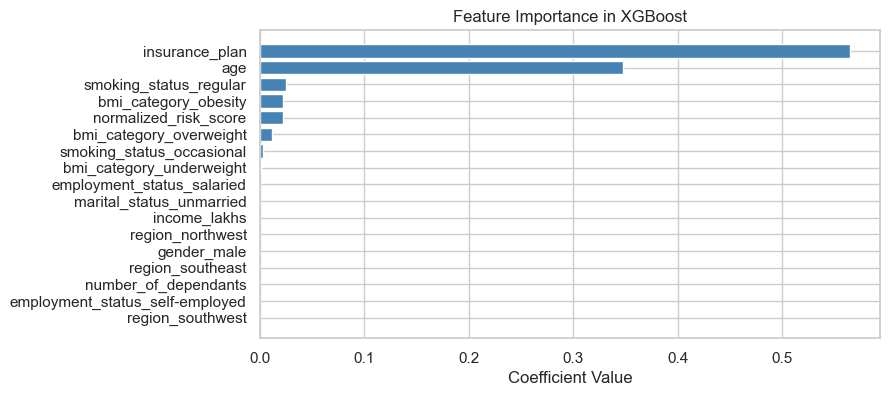

In [82]:


# Same as model_lr.coef_ in Linear Regression
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(data = feature_importance, index= X_test.columns, columns=['coefficients'])
coef_df.head()


coef_df = coef_df.sort_values(by='coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['coefficients'], color='steelblue')
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in XGBoost")
plt.show()

## Error Analysis

In [83]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_percentage = (residuals*100)/y_test

result_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'difference': residuals,
    'diff_percentage': residuals_percentage
})

result_df.head()

,actual,predicted,difference,diff_percentage
48124,5787,6980.624512,1193.624512,20.625964
13616,29352,28928.503906,-423.496094,-1.442819
6518,15094,14718.833008,-375.166992,-2.485537
2096,11729,12120.064453,391.064453,3.334167
29965,23283,23299.072266,16.072266,0.069030


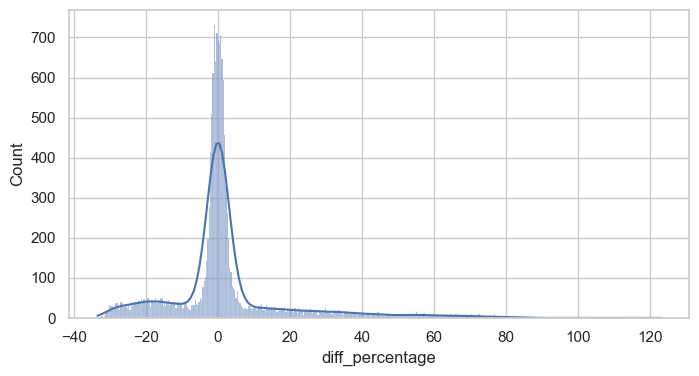

In [84]:
plt.figure(figsize=(8,4))
sns.histplot(x='diff_percentage', data=result_df, kde=True)
plt.show()

From above it is clear that there are some value which is predicted wrong more than `+-(20%)`` error margin. Which is not good for customer and for business as well. So as per out strict allocation error margin should be minimum of 10% or even low.

In [85]:
# We will find how many records has more than 10% margin from all predicted data.
extreme_error_threshold = 10
extreme_result_df = result_df[np.abs(result_df['diff_percentage']) > extreme_error_threshold]
extreme_result_df.shape

(4470, 4)

In [86]:
extreme_result_df.head()

,actual,predicted,difference,diff_percentage
48124,5787,6980.624512,1193.624512,20.625964
13674,10130,7145.133789,-2984.866211,-29.465609
22559,6973,7937.512207,964.512207,13.832098
12312,7755,6553.760742,-1201.239258,-15.489868
43629,8344,6711.082520,-1632.917480,-19.569960


In [87]:
extreme_error_percentage = (extreme_result_df.shape[0] * 100)/result_df.shape[0]
extreme_error_percentage

29.80596119223845

Error margin is 29.80 almost ~30% which should be less than 10% as per our business requirements.

In [88]:
result_df[np.abs(result_df['diff_percentage']) > 50].shape

(508, 4)

Also, we have 508 records which are making mistakes in prediction more than 50% and some of them is almost twice the original price for insurance premium. So this model is not ready to deploy.

 Let's find reason behind these error. Why model is making such a high margin error. After that we will figure out to minimize these error

In [89]:
extreme_result_df.index

Index([48124, 13674, 22559, 12312, 43629,  4284, 23729,  8005, 25255,  7188,
       ...
       35735,  7127, 18618,  7301, 22201, 21699, 36678,  8875, 23136, 12333],
      dtype='int64', length=4470)

In [90]:
X_test.index

Index([48124, 13616,  6518,  2096, 29965, 16539, 12455,   480, 12202, 43342,
       ...
       40928, 45280, 31014,  7586,  8875, 36313, 23136, 42482, 34872, 12333],
      dtype='int64', length=14997)

In [91]:
extreme_error_df = X_test.loc[extreme_result_df.index]
extreme_error_df.shape

(4470, 17)

In [92]:
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
48124,0.000000,0.0,0.060606,0.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0
13674,0.074074,0.2,0.080808,0.0,0.000000,1,0,0,1,1,0,0,1,0,1,0,0
22559,0.055556,0.0,0.060606,0.0,0.000000,1,1,0,0,1,1,0,0,0,1,0,0
12312,0.111111,0.2,0.060606,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
43629,0.055556,0.0,0.040404,0.0,0.428571,1,0,0,1,1,0,0,0,0,0,1,0


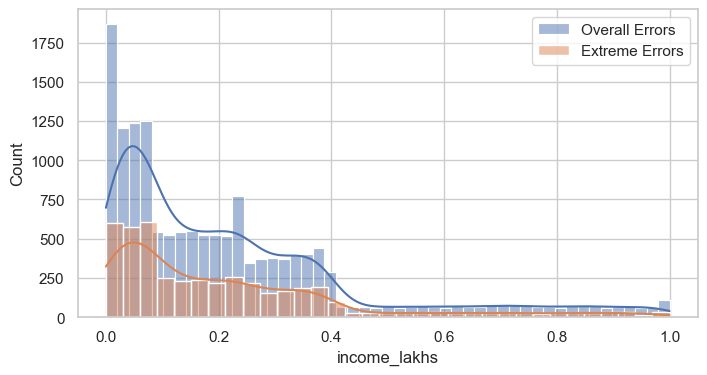

In [93]:
# We will plot distribution of test data and extreme error to figure that is there any insight.
plt.figure(figsize=(8,4))
sns.histplot(X_test['income_lakhs'], label="Overall Errors", kde=True)
sns.histplot(extreme_error_df['income_lakhs'], label="Extreme Errors", kde=True)
plt.legend()
plt.show()

Distribution of both error are same. So its has no any issues with income_lakhs column.

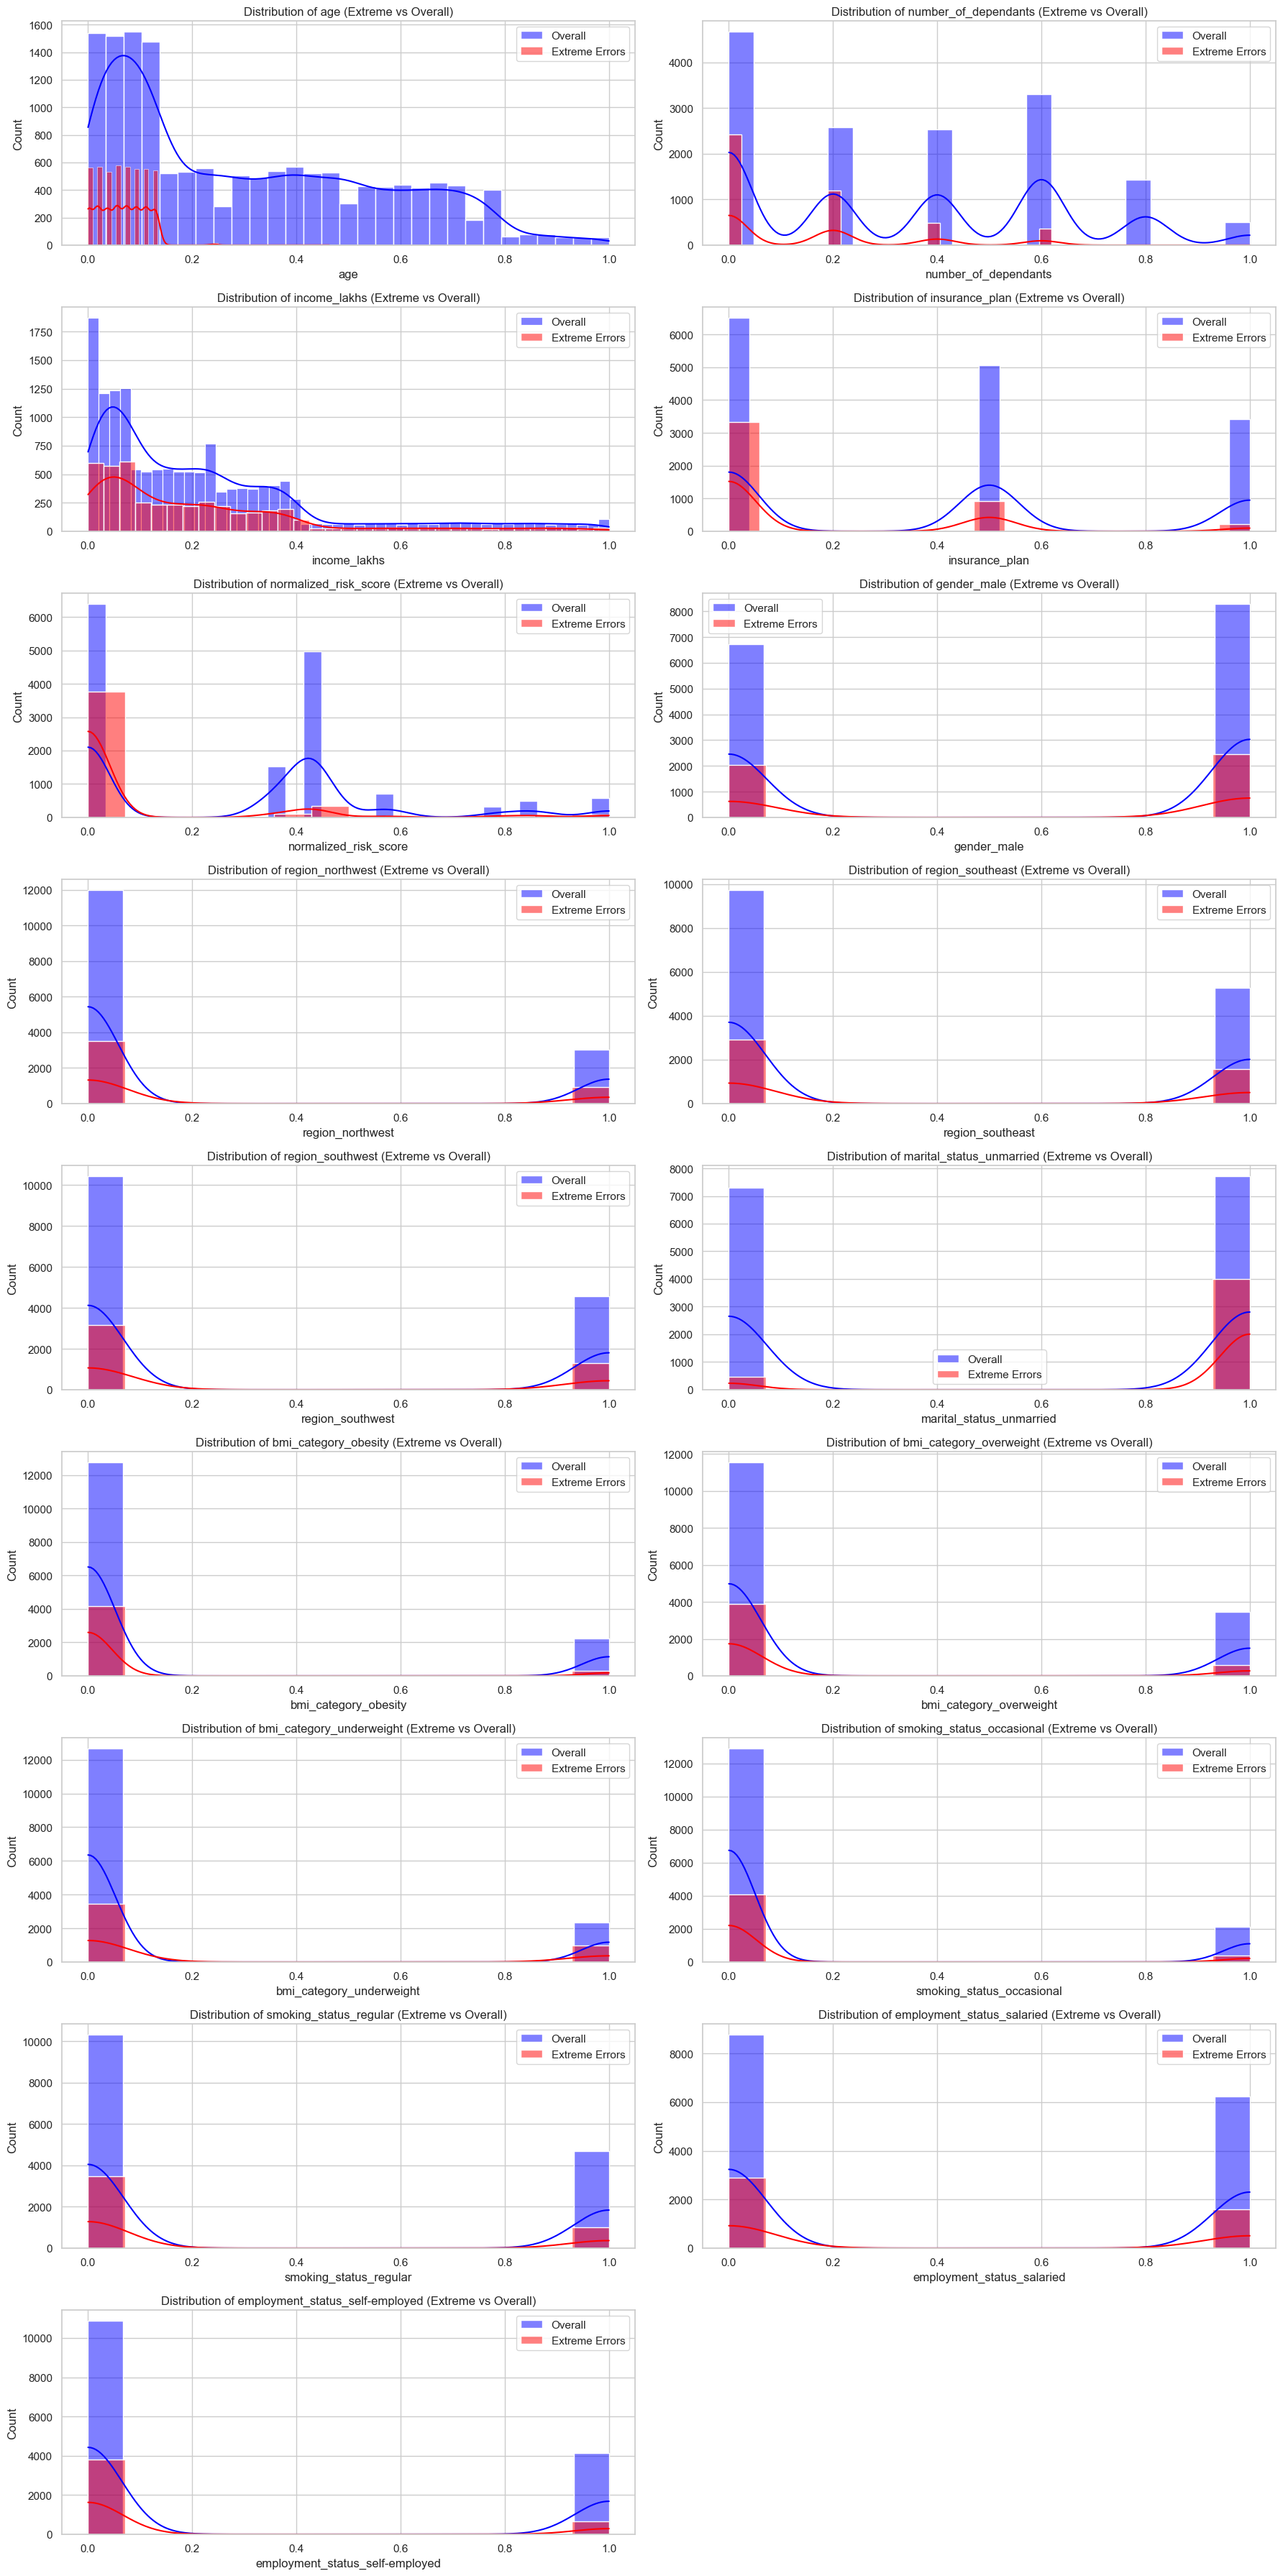

In [94]:
import math

# Number of features to plot
features = X_test.columns
n_features = len(features)

# Grid size (auto-calculated)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of 1D row

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True, ax=ax)
    sns.histplot(extreme_error_df[feature], color='red', label='Extreme Errors', kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature} (Extreme vs Overall)')
    ax.legend()

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


From above distribution we figure out Age column has issues especially with lower age group.

In [95]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [96]:
extreme_error_df['income_level'] = -1
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] =  scaler.inverse_transform(extreme_error_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,18.0,0.0,-2.0,7.0,1.0
1,22.0,1.0,-2.0,9.0,1.0
2,21.0,0.0,-2.0,7.0,1.0
3,24.0,1.0,-2.0,7.0,1.0
4,21.0,0.0,-2.0,5.0,1.0


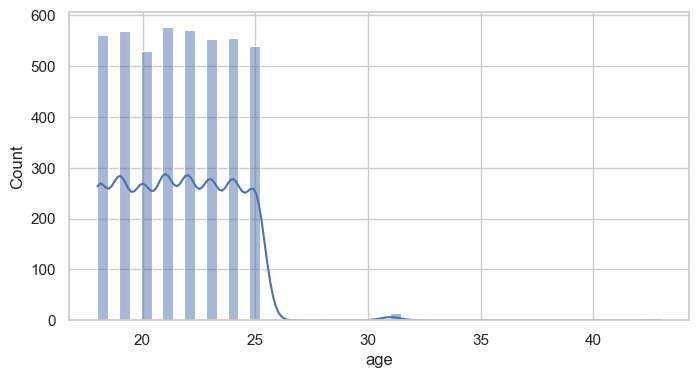

In [97]:
plt.figure(figsize=(8,4))
sns.histplot(df_reversed['age'], kde=True)
plt.show()

In [100]:
df_reversed['age'].quantile(0.99)

25.0

In [104]:
df_reversed[df_reversed['age'] > 25]

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
543,31.0,0.0,-2.0,23.0,1.0
679,31.0,2.0,-2.0,37.0,1.0
1778,43.0,1.0,-2.0,5.0,1.0
1782,31.0,2.0,-2.0,8.0,1.0
2165,31.0,1.0,-2.0,5.0,1.0
2172,31.0,0.0,-2.0,16.0,1.0
2634,31.0,1.0,-2.0,6.0,2.0
2849,31.0,1.0,-2.0,8.0,1.0
2889,31.0,5.0,-2.0,17.0,3.0
3109,31.0,3.0,-2.0,15.0,3.0


In [103]:
df_reversed.shape

(4470, 5)

There is issues in age group because 99% of record has age <=25. Which skewed the data and causes major issues in extreme error.

## Model Monitoring and Feedback Using MLOps